In [1]:
from functools import partial
from samplers import exponential_kernel, BlackOutSampler, MeanSampler, BlurSampler
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import skimage.segmentation as seg

from lime import ImageExplainer
from torchvision import models

from samplers import LatentSampler
from models import GLOW
import torch
from torchvision import transforms

import pickle


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(96),
    transforms.CenterCrop(96),
])

flow = GLOW(3, 32, (3, 96, 96), 40, 256)
flow.model.load_state_dict(torch.load('models/glow/glow_celeba_3_32_256_50000.pt', map_location='cuda'))

manipulators = pickle.load(open('latent_manipulators.pkl', 'rb'))
manipulators = torch.stack([v for k, v in manipulators.items()])

image = Image.open("./data/000010.jpg")
image = transform(image).numpy()

segmentation_fn = partial(seg.slic, n_segments=35, compactness=10)
kernel_fn = partial(exponential_kernel, kernel_width=0.25, distance_metric='cosine')
flow_sampler = partial(LatentSampler, kernel_fn=kernel_fn, model=flow, preprocessor=transform, manipulators=manipulators, radius=5)
black_out_sampler = partial(BlackOutSampler, kernel_fn=kernel_fn)

model = models.resnet34(num_classes=40).to('cuda')
model.load_state_dict(torch.load('./models/resnet_celeba.pt', map_location='cuda', weights_only=True))

explainer1 = ImageExplainer(model, segmentation_fn, flow_sampler)
explainer2 = ImageExplainer(model, segmentation_fn, black_out_sampler)

/home/mando/glime/.venv/lib/python3.10/site-packages/torch/_tensor.py:791: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1984.)
  LU, pivots, infos = torch._lu_with_info(
/tmp/ipykernel_14845/1214715199.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detai

In [14]:
# Flow sampler
explanation1 = explainer1.explain(image, 9, 1000)

# Blackout sampler
explanation2 = explainer2.explain(image, 9, 1000)

100%|██████████| 1000/1000 [00:01<00:00, 822.18it/s]


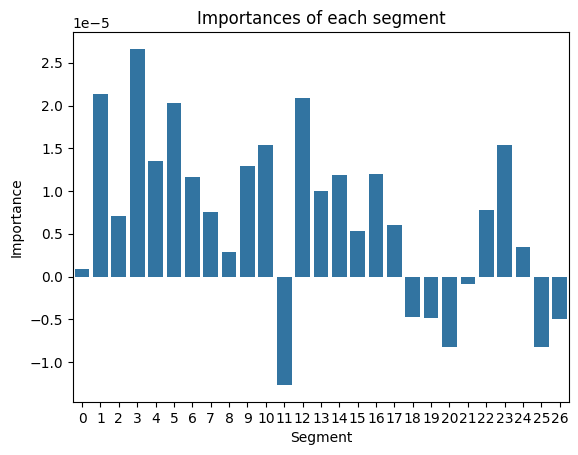

In [15]:
explanation1.plot_importances()

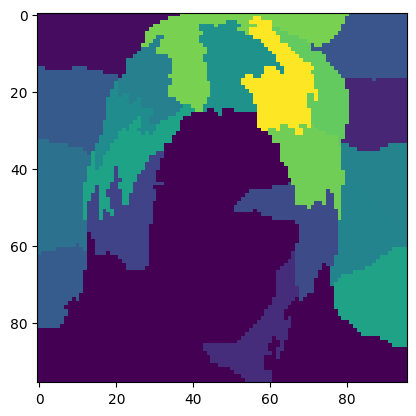

In [16]:
explanation1.render(positive_only=True)

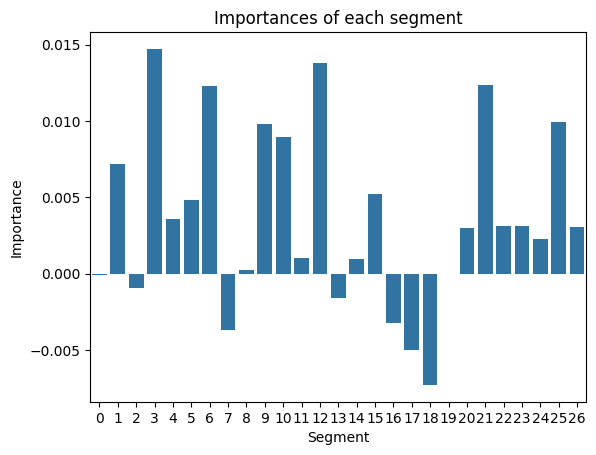

In [17]:
explanation2.plot_importances()

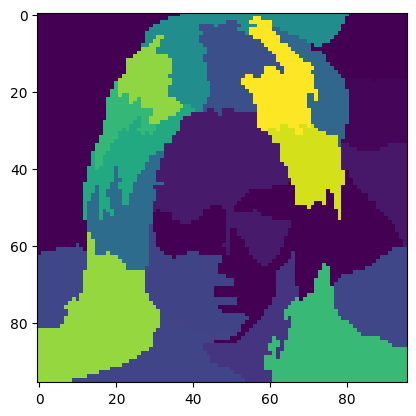

In [18]:
explanation2.render(positive_only=True)

In [7]:
explanation1._samples[10][0]

array([0.91482383, 2.19861579, 4.35215425, 0.88529253, 1.64140892,
       2.0932343 , 0.82047808, 1.5717324 , 2.33304811, 0.65748227,
       1.171031  , 2.51036072, 0.83829528, 1.95399153, 4.95484447,
       0.76048392, 2.25718737, 0.83882236, 1.19420552, 2.87791753,
       2.44543171, 2.6355617 , 1.78069067, 4.80464649, 2.33054256,
       2.36320019, 1.27572215])